## Allstate Claims Severity
[Kaggle](https://www.kaggle.com/c/allstate-claims-severity)  

One of my first attempts with neural networks - I'll use popular kaggle dataset and try to predict claims severity. There are strong "business reasons" to do such taks with help machine/deep learning. After all, when an accidents happens, the vicitms, their families and insurance comapnies have plenty of things to do. So doing some tasks without human involvement can actually be beneficial in this hard moments for all of them.

I will try to predict claims severity with MLP and XGBoost regressor, and finally - combine the results

This small project was part of my course work during [DataWorkshop](http://www.dataworkshop.eu/), so big thanks to Vladimir for all your help & advice 

In [0]:
import pandas as pd
import numpy as np
np.random.seed(2017)

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.model_selection import KFold, train_test_split, learning_curve, ShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial

Using TensorFlow backend.


Sidenote: before loading the data, types have been optimized to use less space (even 7 times in this case, simply by changing float64 to float16, wherever I can)

## Load data

In [0]:
train = pd.read_hdf('../input/train.allstate.h5')

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float16(14), float64(1), int16(2), int32(1), int8(114)
memory usage: 29.8 MB


## Are there any missing values?

In [0]:
train.isnull().any().any() #typical for kaggle datasets

False

## Target variable 

Looking at distribution

In [0]:
train['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

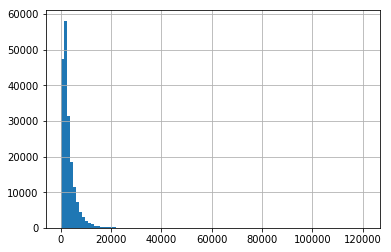

In [0]:
train['loss'].hist(bins=100)

Apparently it's highly skewed - let's check some outliers (top 1% percentile)

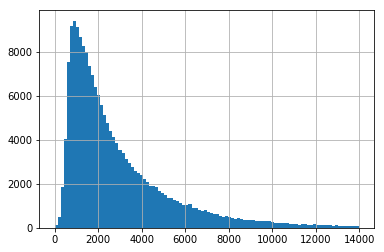

In [0]:
train[ train.loss < np.percentile(train.loss, 99) ]['loss'].hist(bins=100)

Let's do log transformation, to make our distribution more 'regular'

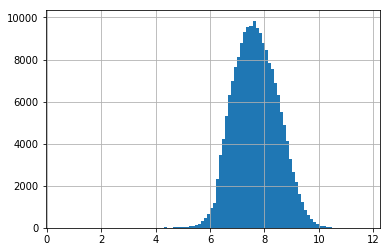

In [0]:
train['log_loss'] = np.log( train['loss'] + 1 ) #pamiętaj o +1 albo spróbuj np.log(0) w osobnej komórce
train['log_loss'].hist(bins=100)

Some 'loose' bins on the left... Let's check them

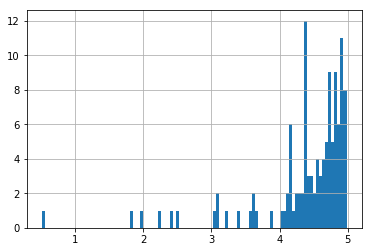

In [0]:
train[ train.log_loss < 5 ]['log_loss'].hist(bins=100)

To get rid of this, lets' add 50 instead of 1 to our function

In [0]:
log_shift = 50

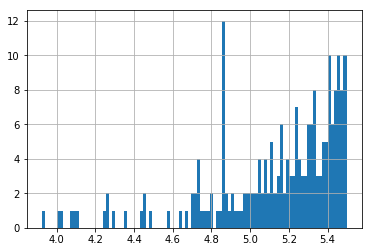

In [0]:
train['log_loss'] = np.log( train['loss'] + log_shift ) #zmienić an shift, odjać potem
train[ train.log_loss < 5.5 ]['log_loss'].hist(bins=100)

Look at it once again. 
Better? Better.

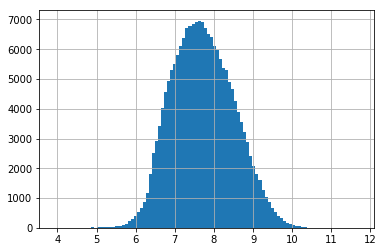

In [0]:
train['log_loss'].hist(bins=100)

## Categorical features
All have "cat" prefix

In [0]:
cat_feats = [feat for feat in train.columns if 'cat' in feat]
print(len(cat_feats),  cat_feats)

116 ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'ca

Quite a lot, huh? Let's check uniqe values of each categorical feature

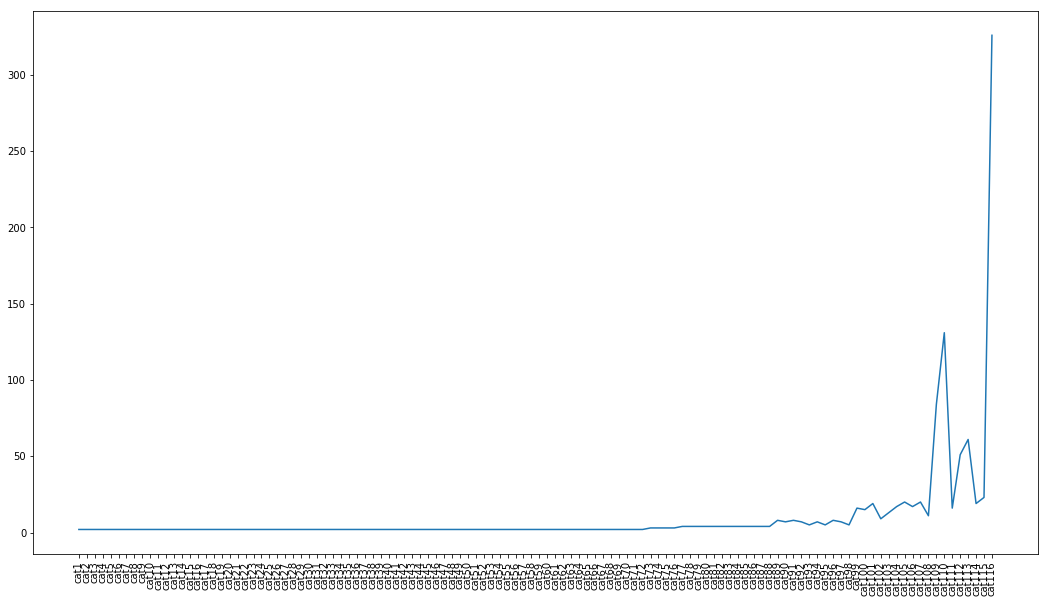

In [0]:
unq_values = [train[feat].nunique() for feat in cat_feats]

id_cat_feats = range(len(cat_feats))
plt.figure(figsize=(18, 10))
plt.plot(id_cat_feats, unq_values)
plt.xticks(id_cat_feats, cat_feats, rotation='vertical');

Most of them have only two values, but same many more. It's hard to look at features with realtively small number of values, but we can change it easily:

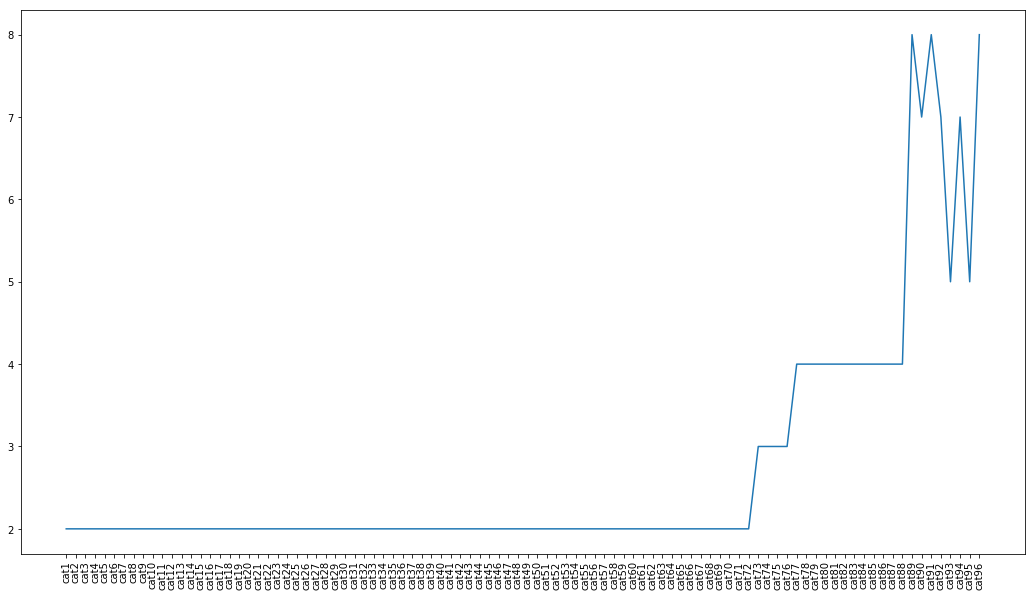

In [0]:
cut_last_elems = 20
plt.figure(figsize=(18, 10))
plt.plot(id_cat_feats[:-cut_last_elems], unq_values[:-cut_last_elems])
plt.xticks(id_cat_feats[:-cut_last_elems], cat_feats[:-cut_last_elems], rotation='vertical');

It seems that after certain number of features (e.g 96), the number of unique values rapidly increases

## Continuous features
All have "cont" prefix

In [0]:
cont_feats = [feat for feat in train.columns if 'cont' in feat]
print(len(cont_feats),  cont_feats)

14 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


Only 14 of them - they're evidently outnumbered by categorical ones... Let's check distributions

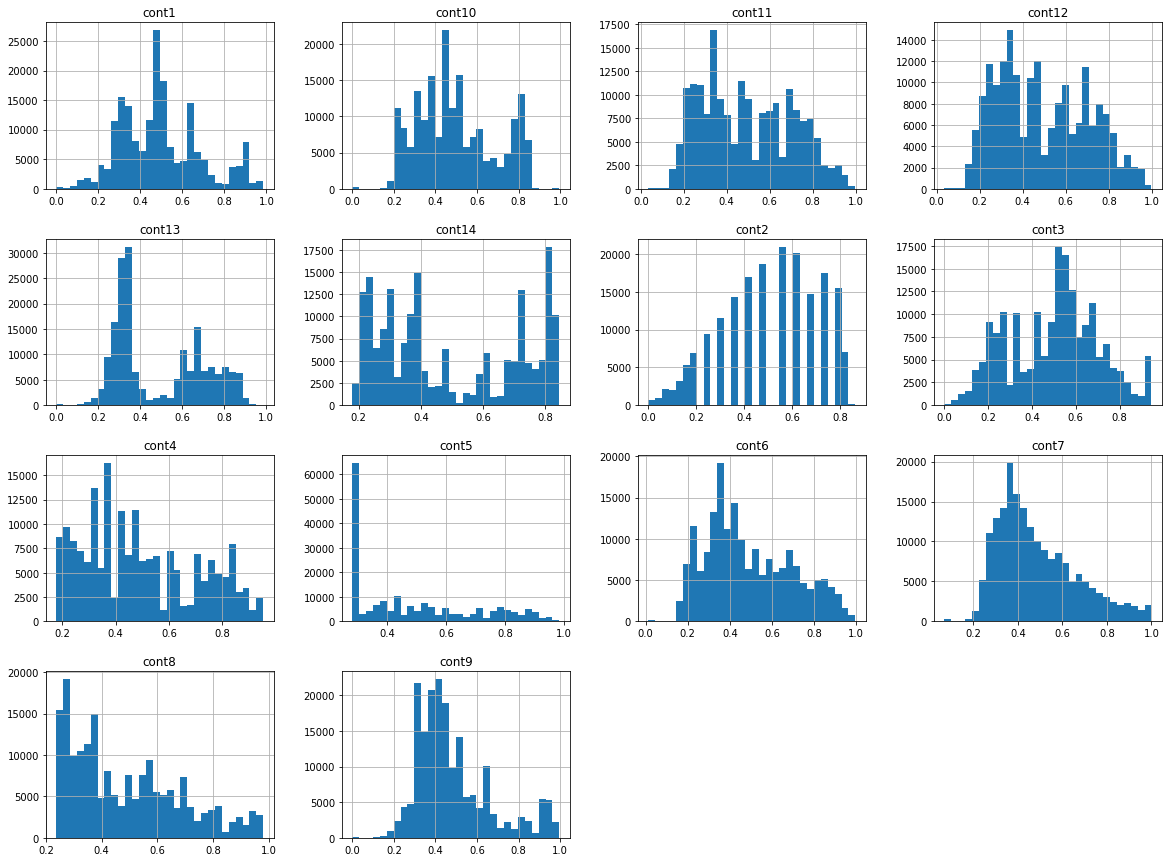

In [0]:
train[ cont_feats ].hist(bins=30, figsize=(20, 15));

## Evaluation
Chosen success metric: **[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)**.

## Base Line - dummy regressor
Let's build the simplest model

In [0]:
def base_line_model(train, target_variable='loss', strategy='mean'):
    X = train[cont_feats].values
    y = train[target_variable].values

    model = DummyRegressor(strategy=strategy)
    model.fit(X, y)
    y_pred = model.predict(X)

    if target_variable == 'log_loss':
        y = np.exp(y) - log_shift
        y_pred = np.exp(y_pred) - log_shift
        y_pred[ y_pred < 0 ] = 0

    score = mean_absolute_error(y, y_pred)
        
    return score

for strategy in ['mean', 'median']:
    for target_variable in ['loss', 'log_loss']:
        score = base_line_model(train, target_variable=target_variable, strategy=strategy)
        print(strategy, target_variable, score)

mean loss 1966.16528556
mean log_loss 1810.36051062
median loss 1809.04878647
median log_loss 1809.04878647


Here we have score achieved by 'dummy' regressor (focused on simple mean or median) - this will serve as 'baseline' for more advanced models.

## Preparing data for NN

In [0]:
df_train = train #.sample(10000) #zmniejszamy ilość danych, żeby szybciej liczyło się
y = df_train['log_loss'].values

## Categorical features

In [0]:
sparse_data = []

feat_cats = [f for f in df_train.columns if 'cat' in f]
for feat in feat_cats:
    dummy = pd.get_dummies(df_train[feat].astype('category'))
    tmp = csr_matrix(dummy)
    sparse_data.append(tmp)

## Continous features

In [0]:
f_num = [f for f in df_train.columns if 'cont' in f]
scaler = StandardScaler()
tmp = csr_matrix(scaler.fit_transform(df_train[f_num]))
sparse_data.append(tmp)

X = hstack(sparse_data, format = 'csr')
X

<188318x1153 sparse matrix of type '<class 'numpy.float64'>'
	with 24481340 stored elements in Compressed Sparse Row format>

## NN - Architecture

In [0]:
def nn_model(input_dim):
    model = Sequential()

    model.add(Dense(512, input_dim = input_dim))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    
    #model.add(Dense(32))
    #model.add(PReLU())
    #model.add(BatchNormalization())
    #model.add(Dropout(0.15))

    model.add(Dense(1))
    model.compile(loss = 'mae', optimizer = 'adadelta')
    return(model)

In [0]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])

    if shuffle:
        np.random.shuffle(sample_index)
        
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch

        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0
            
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0

## Training

In [0]:
nepochs = 200
nfolds = 3

cv = KFold(n_splits=nfolds, shuffle = True, random_state = 2017)

y_preds_nn = []
y_tests_nn= []
scores = []

for num_iter, (train_index, test_index) in enumerate(cv.split(y)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test   = X[test_index], y[test_index]
        
    model = nn_model(X_train.shape[1])

    model.fit_generator(generator = batch_generator(X_train, y_train, 128, True),
                                  epochs = nepochs,
                                  steps_per_epoch = 100,
                                  validation_data=(X_test.todense(), y_test),
                                  validation_steps=62.5,
                                  verbose = 2) 
    
    y_pred = (np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0]))-log_shift
    score = mean_absolute_error((np.exp(y_test))-log_shift, y_pred)
    print("Fold{0}, score={1}".format(num_iter+1, score))
    
    scores.append(score)
    y_tests_nn.append((np.exp(y_test))-log_shift)
    y_preds_nn.append(y_pred)

Epoch 1/200
10s - loss: 7.4080 - val_loss: 7.2626
Epoch 2/200
10s - loss: 6.3194 - val_loss: 5.8183
Epoch 3/200
10s - loss: 3.4611 - val_loss: 1.2707
Epoch 4/200
9s - loss: 1.4639 - val_loss: 0.8001
Epoch 5/200
9s - loss: 1.1928 - val_loss: 0.6113
Epoch 6/200
10s - loss: 1.0711 - val_loss: 0.6033
Epoch 7/200
10s - loss: 0.9935 - val_loss: 0.5798
Epoch 8/200
10s - loss: 0.9380 - val_loss: 0.5432
Epoch 9/200
9s - loss: 0.8981 - val_loss: 0.5388
Epoch 10/200
10s - loss: 0.8620 - val_loss: 0.5060
Epoch 11/200
10s - loss: 0.8302 - val_loss: 0.5044
Epoch 12/200
10s - loss: 0.8050 - val_loss: 0.4819
Epoch 13/200
10s - loss: 0.7750 - val_loss: 0.4585
Epoch 14/200
10s - loss: 0.7528 - val_loss: 0.4482
Epoch 15/200
10s - loss: 0.7309 - val_loss: 0.4578
Epoch 16/200
10s - loss: 0.7198 - val_loss: 0.4568
Epoch 17/200
10s - loss: 0.6968 - val_loss: 0.4485
Epoch 18/200
10s - loss: 0.6841 - val_loss: 0.4406
Epoch 19/200
9s - loss: 0.6769 - val_loss: 0.4465
Epoch 20/200
10s - loss: 0.6716 - val_loss: 

9s - loss: 0.4988 - val_loss: 0.4076
Epoch 163/200
9s - loss: 0.4919 - val_loss: 0.4128
Epoch 164/200
9s - loss: 0.4997 - val_loss: 0.4107
Epoch 165/200
9s - loss: 0.4952 - val_loss: 0.4149
Epoch 166/200
9s - loss: 0.4946 - val_loss: 0.4103
Epoch 167/200
9s - loss: 0.4941 - val_loss: 0.4112
Epoch 168/200
9s - loss: 0.4948 - val_loss: 0.4131
Epoch 169/200
9s - loss: 0.4932 - val_loss: 0.4089
Epoch 170/200
9s - loss: 0.4911 - val_loss: 0.4093
Epoch 171/200
9s - loss: 0.4916 - val_loss: 0.4138
Epoch 172/200
9s - loss: 0.4928 - val_loss: 0.4075
Epoch 173/200
9s - loss: 0.4921 - val_loss: 0.4126
Epoch 174/200
9s - loss: 0.4958 - val_loss: 0.4082
Epoch 175/200
9s - loss: 0.4922 - val_loss: 0.4109
Epoch 176/200
9s - loss: 0.4973 - val_loss: 0.4071
Epoch 177/200
9s - loss: 0.4932 - val_loss: 0.4078
Epoch 178/200
9s - loss: 0.4843 - val_loss: 0.4185
Epoch 179/200
9s - loss: 0.4913 - val_loss: 0.4086
Epoch 180/200
9s - loss: 0.4896 - val_loss: 0.4088
Epoch 181/200
9s - loss: 0.4900 - val_loss: 0

9s - loss: 0.5106 - val_loss: 0.4133
Epoch 126/200
9s - loss: 0.5074 - val_loss: 0.4098
Epoch 127/200
9s - loss: 0.5073 - val_loss: 0.4087
Epoch 128/200
9s - loss: 0.5041 - val_loss: 0.4136
Epoch 129/200
9s - loss: 0.5087 - val_loss: 0.4108
Epoch 130/200
9s - loss: 0.5083 - val_loss: 0.4115
Epoch 131/200
9s - loss: 0.5079 - val_loss: 0.4113
Epoch 132/200
9s - loss: 0.5036 - val_loss: 0.4150
Epoch 133/200
9s - loss: 0.5011 - val_loss: 0.4168
Epoch 134/200
9s - loss: 0.5043 - val_loss: 0.4072
Epoch 135/200
9s - loss: 0.5112 - val_loss: 0.4175
Epoch 136/200
9s - loss: 0.5046 - val_loss: 0.4083
Epoch 137/200
9s - loss: 0.4988 - val_loss: 0.4095
Epoch 138/200
9s - loss: 0.5038 - val_loss: 0.4099
Epoch 139/200
9s - loss: 0.5001 - val_loss: 0.4107
Epoch 140/200
9s - loss: 0.5060 - val_loss: 0.4136
Epoch 141/200
9s - loss: 0.4973 - val_loss: 0.4189
Epoch 142/200
9s - loss: 0.5082 - val_loss: 0.4118
Epoch 143/200
9s - loss: 0.5003 - val_loss: 0.4094
Epoch 144/200
9s - loss: 0.5024 - val_loss: 0

9s - loss: 0.5313 - val_loss: 0.4115
Epoch 88/200
10s - loss: 0.5316 - val_loss: 0.4135
Epoch 89/200
9s - loss: 0.5350 - val_loss: 0.4097
Epoch 90/200
9s - loss: 0.5224 - val_loss: 0.4161
Epoch 91/200
9s - loss: 0.5258 - val_loss: 0.4136
Epoch 92/200
9s - loss: 0.5298 - val_loss: 0.4149
Epoch 93/200
9s - loss: 0.5264 - val_loss: 0.4107
Epoch 94/200
9s - loss: 0.5224 - val_loss: 0.4152
Epoch 95/200
9s - loss: 0.5175 - val_loss: 0.4164
Epoch 96/200
10s - loss: 0.5215 - val_loss: 0.4205
Epoch 97/200
9s - loss: 0.5243 - val_loss: 0.4102
Epoch 98/200
9s - loss: 0.5251 - val_loss: 0.4117
Epoch 99/200
9s - loss: 0.5218 - val_loss: 0.4122
Epoch 100/200
9s - loss: 0.5169 - val_loss: 0.4137
Epoch 101/200
9s - loss: 0.5206 - val_loss: 0.4170
Epoch 102/200
9s - loss: 0.5188 - val_loss: 0.4151
Epoch 103/200
9s - loss: 0.5197 - val_loss: 0.4110
Epoch 104/200
9s - loss: 0.5173 - val_loss: 0.4142
Epoch 105/200
9s - loss: 0.5134 - val_loss: 0.4169
Epoch 106/200
9s - loss: 0.5242 - val_loss: 0.4135
Epoc

In [0]:
np.mean(scores)


1164.9259660715263

## NN & XGBoost on the same split

### First model - NN

In [0]:
#import numpy as np

In [0]:
#common split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [0]:
#reverse transformation
#X_train_log = (np.exp(X_train)) - log_shift
#X_test_log = np.exp(X_test) - log_shift

#y_train_log = np.exp(y_train) - log_shift
#y_test_log = np.exp(y_test) - log_shift

In [0]:
#already trained - predict only
    
y_pred_nn = (np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0]))-log_shift  
y_pred_nn_train = (np.exp(model.predict_generator(generator = batch_generatorp(X_train, 128, False), steps = X_test.shape[0])[:,0]))-log_shift

In [0]:
#y_pred_nn

In [0]:
#score on test and train set -> to  spot potential overfitting
mean_absolute_error((np.exp(y_test))-log_shift, y_pred_nn), mean_absolute_error((np.exp(y_train))-log_shift, y_pred_nn_train)

(1136.4458447996337, 1139.5872935766567)

In [0]:
#quite promising ^

### Second Model - XGBregressor

In [0]:
#instatiate model - parameters from hyperopt/some experiments
xgb_model = XGBRegressor(colsample_bytree= 0.5, 
                         n_estimators=1000,
                         learning_rate= 0.01, 
                         max_depth= 10,
                         min_child_weight= 5, 
                         reg_alpha= 2.03,
                         reg_lambda= 0.85, 
                         seed= 6300, 
                         subsample= 0.5)

xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=2.03, reg_lambda=0.85, scale_pos_weight=1, seed=6300,
       silent=True, subsample=0.5)

In [0]:
#fit it to the same data as NN above
xgb_model.fit(X_train, y_train)    
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_train = xgb_model.predict(X_train) 

In [0]:
#reverse
y_pred_xgb = np.exp(y_pred_xgb)-log_shift
y_pred_xgb_train = np.exp(y_pred_xgb_train)-log_shift

In [0]:
#score second model - is it any better than NN?
mean_absolute_error(np.exp(y_test)-log_shift, y_pred_xgb), mean_absolute_error(np.exp(y_train), y_pred_xgb_train)

(1148.4671401346955, 1055.6095619473656)

In [0]:
#make custom metric - mae with log shift to reverse transformation
def my_mae(y, y_pred):
    return np.sum(np.absolute((((np.exp(y_pred.astype("float")))-50) - ((np.exp(y.astype("float"))-50)))))/len(y)

In [0]:
#check overfitting and overall performance with this function
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(my_mae))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

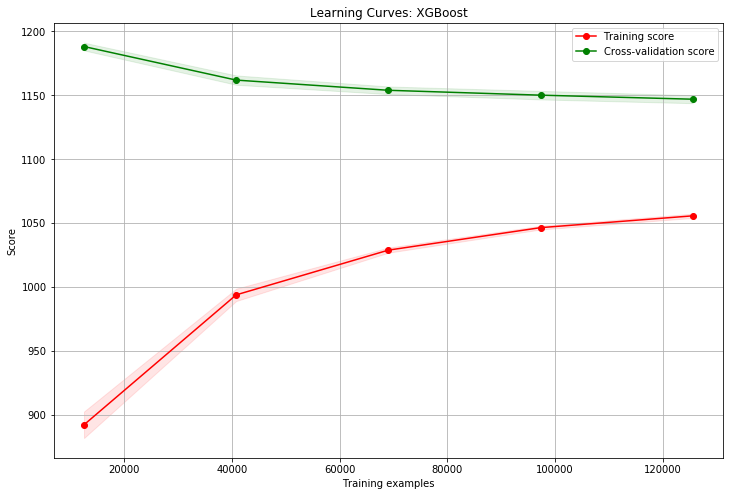

In [0]:
plt = plot_learning_curve(xgb_model, "Learning Curves: XGBoost", X, y, cv=3, n_jobs=-1) 
plt.show()

# Combine!

### Final score from previous two

In [0]:
pred_combined = (y_pred_xgb + y_pred_nn)/2 
#eksperymenty z wagi, wrzucić na kaggla, ew. overfitting + wnioski, 
#z xgboost optymalizacji da się coś wycisnąć

In [0]:
pred_combined

array([  1071.07397461,   1794.1307373 ,   1893.58837891, ...,
         1355.07043457,   2266.56982422,  12647.1171875 ], dtype=float32)

In [0]:
mean_absolute_error(np.exp(y_test)-log_shift, pred_combined)

1133.0219171268195

# Conclusions

We can sognificantly improve our results without "stacking" simply by averaging outputs from two different models. Final results is quite good - I expected MAE aroung 1150, and get 1133, with some space for improvements. This can helps us improve insurance industry -  when insurance agents dont have to focus on task which can be autometed, the can focus more on *people*. I believe it is great improvement.